In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from candy import Candy
from analysis import *
from torch.utils.data import random_split
import matplotlib.pyplot as plt


In [28]:
raw = pd.read_csv('generated/results_100000.csv')

/var/folders/n7/7ln3k6zx5hj40n1dc441clm40000gn/T/ipykernel_55930/340975548.py:1: DtypeWarning:

Columns (69,72,75,78,81,84,87,90,93,96) have mixed types. Specify dtype option on import or set low_memory=False.



In [29]:
raw

,Explo,n_rollout,n_simulation,n_random,state,Move_1,Move_1_N,Move_1_Q,Move_2,Move_2_N,...,Move_28_Q,Move_29,Move_29_N,Move_29_Q,Move_30,Move_30_N,Move_30_Q,Move_31,Move_31_N,Move_31_Q
0,2000,2,3000,2,4060204050402040605030505010201030406030501030...,"((3, 3), (4, 3))",2885,1852.772270,"((2, 5), (2, 6))",22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,2,3000,2,5010502060303050105050105060304030103040306060...,"((1, 4), (1, 5))",2737,899.568871,"((4, 4), (4, 5))",55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,2,3000,2,6020404060402010104030302030504010302040302050...,"((3, 4), (3, 5))",330,281.890909,"((2, 0), (2, 1))",287.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,2,3000,2,4060105050406060201030602030506040606040105040...,"((3, 4), (4, 4))",502,193.824701,"((2, 1), (2, 2))",465.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,2,3000,2,6010304040305060404030205010506060201050204050...,"((1, 3), (1, 4))",677,237.955687,"((2, 0), (2, 1))",420.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2000,2,3000,2,1010304040203060304030605010402030406350403040...,"((0, 2), (1, 2))",1173,813.895993,"((3, 4), (3, 5))",393.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99996,2000,2,3000,2,1050502060404010605050301060305060205020401040...,"((2, 4), (3, 4))",2358,1269.733673,"((4, 2), (4, 3))",87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99997,2000,2,3000,2,1050206050406050103040604020404020604020402060...,"((1, 4), (1, 5))",364,288.615385,"((4, 4), (4, 5))",347.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99998,2000,2,3000,2,4030506030103050602050606050101060101030506030...,"((4, 4), (4, 5))",420,238.047619,"((4, 3), (5, 3))",337.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Create a list of dictionaries with the boards and scores
data = [{'board': state_to_board(state, 7, 7).board, 'score': score} for state, score in zip(raw["state"], raw["Move_1_Q"])]

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data, columns=['board', 'score'])

In [31]:
df

,board,score
0,"[[4, 6, 2, 4, 5, 4, 2], [4, 6, 5, 3, 5, 5, 1],...",1852.772270
1,"[[5, 1, 5, 2, 6, 3, 3], [5, 1, 5, 5, 1, 5, 6],...",899.568871
2,"[[6, 2, 4, 4, 6, 4, 2], [1, 1, 4, 3, 3, 2, 3],...",281.890909
3,"[[4, 6, 1, 5, 5, 4, 6], [6, 2, 1, 3, 6, 2, 3],...",193.824701
4,"[[6, 1, 3, 4, 4, 3, 5], [6, 4, 4, 3, 2, 5, 1],...",237.955687
...,...,...
99995,"[[1, 1, 3, 4, 4, 2, 3], [6, 3, 4, 3, 6, 5, 1],...",813.895993
99996,"[[1, 5, 5, 2, 6, 4, 4], [1, 6, 5, 5, 3, 1, 6],...",1269.733673
99997,"[[1, 5, 2, 6, 5, 4, 6], [5, 1, 3, 4, 6, 4, 2],...",288.615385
99998,"[[4, 3, 5, 6, 3, 1, 3], [5, 6, 2, 5, 6, 6, 5],...",238.047619


In [34]:

df = pd.DataFrame(data)

# Number of bins
num_bins = 200

# Create bins for the scores
df['score_bin'] = pd.cut(df['score'], bins=num_bins)

# Sample up to 100 rows from each bin
sampled_df = df.groupby('score_bin').apply(lambda x: x.sample(n=min(len(x), 200))).reset_index(drop=True)

# Drop the score_bin column
sampled_df = sampled_df.drop(columns=['score_bin'])

/var/folders/n7/7ln3k6zx5hj40n1dc441clm40000gn/T/ipykernel_55930/160624072.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/n7/7ln3k6zx5hj40n1dc441clm40000gn/T/ipykernel_55930/160624072.py:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



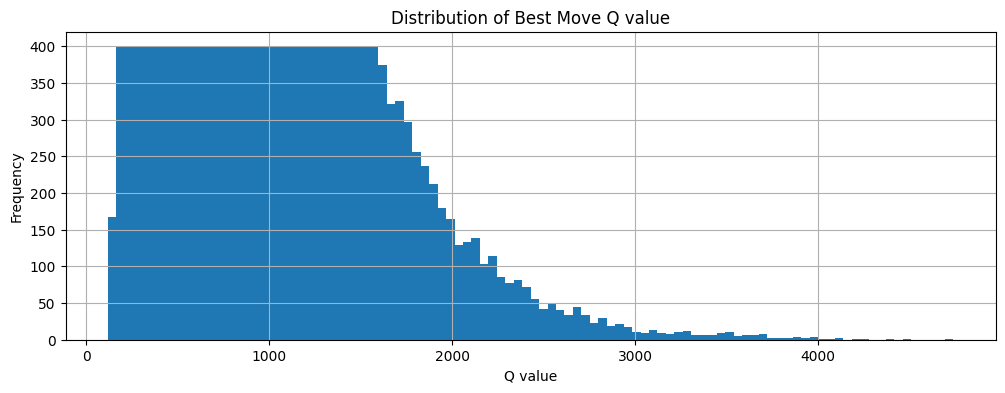

In [35]:
plt.figure(figsize=(12, 4))
sampled_df["score"].hist(bins= 100)
plt.title("Distribution of Best Move Q value")
plt.xlabel("Q value")
plt.ylabel("Frequency")
plt.show()

In [59]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Example unique IDs and types
unique_ids = [1, 2, 3, 4, 5, 6, 7]
unique_types = ["normal", "sachet", "raye_hor", "raye_ver", "disco"]

# Mapping for one-hot encoding
id_to_index = {id_: idx for idx, id_ in enumerate(unique_ids)}
type_to_index = {type_: idx for idx, type_ in enumerate(unique_types)}

# One-hot encode a single Candy object
def one_hot_encode_candy(candy):
    id_one_hot = np.zeros(len(unique_ids))
    type_one_hot = np.zeros(len(unique_types))
    id_one_hot[id_to_index[candy.id]] = 1
    type_one_hot[type_to_index.get(candy.type, 0)] = 1  # Default to first index if type missing
    return np.concatenate([id_one_hot, type_one_hot])

# Convert a 7x7 grid of Candy objects to a numerical 3D array
def preprocess_board(board):
    grid_size = (7, 7)
    encoded_board = np.zeros((*grid_size, len(unique_ids) + len(unique_types)))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            encoded_board[i, j, :] = one_hot_encode_candy(board[i][j])
    return encoded_board


index_to_id = {idx: id_ for id_, idx in id_to_index.items()}
index_to_type = {idx: type_ for type_, idx in type_to_index.items()}

# Decode a single one-hot encoded candy
def decode_candy(encoded_candy):
    id_one_hot = encoded_candy[:len(unique_ids)]
    type_one_hot = encoded_candy[len(unique_ids):]
    
    candy_id = index_to_id[np.argmax(id_one_hot)]
    candy_type = index_to_type[np.argmax(type_one_hot)]
    
    return Candy(candy_id, candy_type)

# Convert a numerical 3D array back to a 7x7 grid of Candy objects
def decode_board(encoded_board):
    grid_size = (7, 7)
    decoded_board = np.empty(grid_size, dtype=object)
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            decoded_board[i, j] = decode_candy(encoded_board[i, j, :])
    return decoded_board



class CandyDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.min_score = dataframe['score'].min()
        self.max_score = dataframe['score'].max()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        board = self.dataframe.iloc[idx, 0]  # Board state
        score = self.dataframe.iloc[idx, 1]  # Score
        #normalized_score = (score - self.min_score) / (self.max_score - self.min_score)  # Min-Max normalization
        processed_board = preprocess_board(board)
        return torch.tensor(processed_board, dtype=torch.float32), torch.tensor(score, dtype=torch.float32)

class CandyCNN(nn.Module):
    def __init__(self):
        super(CandyCNN, self).__init__()
        in_channels = len(unique_ids) + len(unique_types)  # Total channels from encoding
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout layers after the convolutional layers
        self.dropout_conv = nn.Dropout2d(p=0.15)  # Dropout on convolutional feature maps
        
        # Calculate the size after convolutions and pooling
        self._calculate_fc_input_size()

        # Fully connected layers with dropout
        self.fc1 = nn.Linear(self.fc_input_size, 256)  # Adjusted input size
        self.dropout_fc = nn.Dropout(p=0.2)  # Dropout after the first fully connected layer
        self.fc2 = nn.Linear(256, 64)  # Single output for regression
        self.fc3 = nn.Linear(64, 1)  # Single output for regression
        

    def _calculate_fc_input_size(self):
        # Dummy input to calculate output size after convolutions and pooling
        dummy_input = torch.zeros(1, len(unique_ids) + len(unique_types), 7, 7)
        x = self.pool(torch.relu(self.conv1(dummy_input)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        self.fc_input_size = np.prod(x.size()[1:])  # Flattened size after pooling

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout_conv(x)  # Apply dropout to convolutional feature maps
        x = x.reshape(x.size(0), -1) # Flatten for FC layer
        x = torch.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Apply dropout to the first fully connected layer
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
    
# Modified training function to track training and validation loss
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.permute(0, 3, 1, 2))  # Adjust dimensions to (N, C, H, W)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation during validation
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs.permute(0, 3, 1, 2))  # Adjust dimensions to (N, C, H, W)
                loss = criterion(outputs.squeeze(), targets)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        # Print the losses
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    
    # Plot training and validation losses
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss over Epochs')
    plt.show()

Using device: mps


Epoch 1/30, Train Loss: 599214.5420, Validation Loss: 422771.7437
Epoch 2/30, Train Loss: 416291.9417, Validation Loss: 414338.8663
Epoch 3/30, Train Loss: 397802.8581, Validation Loss: 382082.2290
Epoch 4/30, Train Loss: 387962.5911, Validation Loss: 379771.6517
Epoch 5/30, Train Loss: 385798.7555, Validation Loss: 376373.5835
Epoch 6/30, Train Loss: 380159.6612, Validation Loss: 377886.4243
Epoch 7/30, Train Loss: 375465.8267, Validation Loss: 374668.7996
Epoch 8/30, Train Loss: 373032.8799, Validation Loss: 372894.5538
Epoch 9/30, Train Loss: 366481.5969, Validation Loss: 383936.4531
Epoch 10/30, Train Loss: 359499.0103, Validation Loss: 365270.4672
Epoch 11/30, Train Loss: 346645.9977, Validation Loss: 372559.1581
Epoch 12/30, Train Loss: 335136.4172, Validation Loss: 381728.3912
Epoch 13/30, Train Loss: 326123.0405, Validation Loss: 359051.2560
Epoch 14/30, Train Loss: 316870.8639, Validation Loss: 363634.6511
Epoch 15/30, Train Loss: 308522.9186, Validation Loss: 369492.5445
Epoc

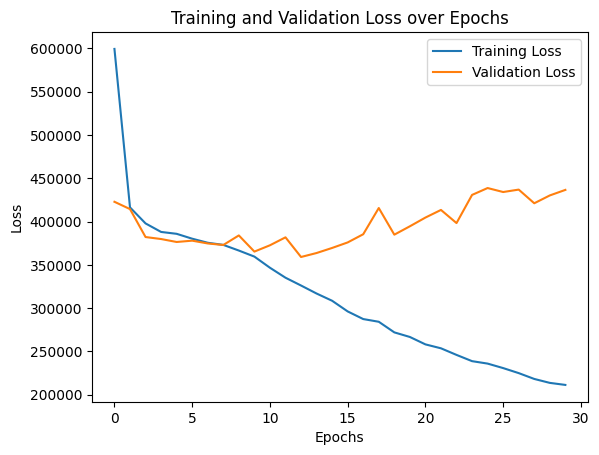

In [48]:


# Create dataset
dataset = CandyDataset(sampled_df)

# Calculate the size of the training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split dataset into train and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize model, loss, and optimizer
model = CandyCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
# Train the model with loss tracking and plotting
train_model(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=30)

In [57]:
import plotly.graph_objects as go

# Show the prediction on the validation set
model.eval()
with torch.no_grad():
    inp = []
    tar = []
    boards = []
    for inputs, targets in val_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs.permute(0, 3, 1, 2))
        inp.extend(outputs.squeeze().cpu().numpy().flatten())
        tar.extend(targets.squeeze().cpu().numpy().flatten())
        boards.extend(inputs.cpu().numpy())  # Store the boards
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=inp, y=tar, mode='markers', name='Predictions vs Targets'))
    fig.add_trace(go.Scatter(x=[0, 3000], y=[0, 3000], mode='lines', name='Ideal Line', line=dict(color='red', dash='dash')))
    fig.update_layout(
        title="Model Predictions vs Targets for Validation Set",
        xaxis_title="Predicted Values",
        yaxis_title="Target Values",
        width=800,
        height=600
    )
    fig.show()

## Show the prediction on the training set
#model.eval()
#with torch.no_grad():
#    inp = []
#    tar = []
#    for inputs, targets in train_dataloader:
#        inputs, targets = inputs.to(device), targets.to(device)
#        outputs = model(inputs.permute(0, 3, 1, 2))
#        inp.extend(outputs.squeeze().cpu().numpy().flatten())
#        tar.extend(targets.squeeze().cpu().numpy().flatten())
#
#    fig = go.Figure()
#    fig.add_trace(go.Scatter(x=inp, y=tar, mode='markers', name='Predictions vs Targets'))
#    fig.add_trace(go.Scatter(x=[0, 3000], y=[0, 3000], mode='lines', name='Ideal Line', line=dict(color='red', dash='dash')))
#    fig.update_layout(
#        title="Model Predictions vs Targets on Training Set",
#        xaxis_title="Predicted Values",
#        yaxis_title="Target Values",
#        width=800,
#        height=600
#    )
#    fig.show()

In [61]:
boards = [decode_board(board) for board in boards]

In [71]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
import pandas as pd
import torch
# Initialize the Dash app
app = dash.Dash(__name__)

# Example data (replace with your actual data)

# Create the scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=inp, y=tar, mode='markers', name='Predictions vs Targets', opacity=0.8))
fig.add_trace(go.Scatter(x=[0, 3000], y=[0, 3000], mode='lines', name='Ideal Line', line=dict(color='red', dash='dash')))
fig.update_layout(
    title="Model Predictions vs Targets",
    xaxis_title="Predicted Values",
    yaxis_title="Target Values",
    width=800,
    height=600
)



# Define the layout of the app
app.layout = html.Div([
    dcc.Graph(id='scatter-plot', figure=fig),
    html.Div(id='board-display'),
    html.Button('Print Board', id='print-button', n_clicks=0)
])

# Define the callback to update the board display
@app.callback(
    Output('board-display', 'children'),
    Input('scatter-plot', 'clickData')
)
def display_board(clickData):
    if clickData is None:
        return "Click on a point to see the board."
    
    point_index = clickData['points'][0]['pointIndex']
    board = boards[point_index]
    
    board_html = html.Table([
        html.Tbody([
            html.Tr([html.Td(html.Img(src=f'assets/candy/candy_{cell}.png', style={'width': '50px'})) for cell in row]) for row in board
        ])
    ])
    
    return board_html

# Define the callback to print the board to the terminal
@app.callback(
    Output('print-button', 'n_clicks'),
    Input('print-button', 'n_clicks'),
    State('scatter-plot', 'clickData')
)
def print_board(n_clicks, clickData):
    if n_clicks > 0 and clickData is not None:
        point_index = clickData['points'][0]['pointIndex']
        board = boards[point_index]
        print("Board at index", point_index)
        for row in board:
            print(row)
    return 0  # Reset the button click count

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

Board at index 785
[Candy(4) Candy(2) Candy(1) Candy(5) Candy(3) Candy(2) Candy(2)]
[Candy(1) Candy(2) Candy(3) Candy(4) Candy(2) Candy(1) Candy(3)]
[Candy(1) Candy(6) Candy(6) Candy(5) Candy(2) Candy(3) Candy(6)]
[Candy(5) Candy(6) Candy(6) Candy(3) Candy(4) Candy(2) Candy(4)]
[Candy(2) Candy(1) Candy(3) Candy(3) Candy(5) Candy(3) Candy(3)]
[Candy(5) Candy(5) Candy(3) Candy(1) Candy(2) Candy(3) Candy(2)]
[Candy(1) Candy(1) Candy(2) Candy(5) Candy(2) Candy(1) Candy(4)]
Board at index 1769
[Candy(5) Candy(6) Candy(4) Candy(5) Candy(3) Candy(5) Candy(5)]
[Candy(1) Candy(3) Candy(1) Candy(3) Candy(4) Candy(6) Candy(6)]
[Candy(3) Candy(6) Candy(3) Candy(3) Candy(4) Candy(3) Candy(3)]
[Candy(6) Candy(2) Candy(6) Candy(2) Candy(2) Candy(4) Candy(6)]
[Candy(4) Candy(6) Candy(2) Candy(6) Candy(1) Candy(2) Candy(1)]
[Candy(3) Candy(3) Candy(4) Candy(2) Candy(6) Candy(4) Candy(1)]
[Candy(6) Candy(3) Candy(2) Candy(2) Candy(4) Candy(2) Candy(4)]
Board at index 1486
[Candy(4) Candy(1) Candy(5) Can

In [76]:
df.iloc[0].board

array([[Candy(4), Candy(6), Candy(2), Candy(4), Candy(5), Candy(4),
        Candy(2)],
       [Candy(4), Candy(6), Candy(5), Candy(3), Candy(5), Candy(5),
        Candy(1)],
       [Candy(2), Candy(1), Candy(3), Candy(4), Candy(6), Candy(3),
        Candy(5)],
       [Candy(1), Candy(3), Candy(2), Candy(2), Candy(4), Candy(5),
        Candy(6)],
       [Candy(5), Candy(2), Candy(2), Candy(6), Candy(2), Candy(2),
        Candy(3)],
       [Candy(5), Candy(4), Candy(3), Candy(6), Candy(5), Candy(1),
        Candy(5)],
       [Candy(3), Candy(3), Candy(6), Candy(2), Candy(5), Candy(2),
        Candy(2)]], dtype=object)

In [102]:
%autoreload 2
from nn import save_model, load_model

UsageError: Line magic function `%autoreload` not found.


In [103]:
md = load_model("model.pth", 'mps')

TypeError: load_model() missing 1 required positional argument: 'device'

In [95]:
save_model(model, "model.pth")

Model saved to model.pth


In [92]:
raw.iloc[i].head(10)

Explo                                                        2000
n_rollout                                                       2
n_simulation                                                 3000
n_random                                                        2
state           4010501020306050502020106050201040305020406050...
Move_1                                           ((4, 5), (5, 5))
Move_1_N                                                     2880
Move_1_Q                                              3616.086111
Move_2                                           ((0, 4), (1, 4))
Move_2_N                                                     23.0
Name: 37478, dtype: object

In [91]:
# find the row where board in interest_board
for i in range(len(df)):
    if np.array_equal(df.iloc[i].board, interest_board3):
        print(i)
        break


37478


In [90]:
interest_board = [[Candy(4), Candy(2), Candy(1), Candy(5), Candy(3), Candy(2), Candy(2),],
                [Candy(1), Candy(2), Candy(3), Candy(4), Candy(2), Candy(1), Candy(3),],
                [Candy(1), Candy(6), Candy(6), Candy(5), Candy(2), Candy(3), Candy(6),],
                [Candy(5), Candy(6), Candy(6), Candy(3), Candy(4), Candy(2), Candy(4),],
                [Candy(2), Candy(1), Candy(3), Candy(3), Candy(5), Candy(3), Candy(3),],
                [Candy(5), Candy(5), Candy(3), Candy(1), Candy(2), Candy(3), Candy(2),],
                [Candy(1), Candy(1), Candy(2), Candy(5), Candy(2), Candy(1), Candy(4),],]


interest_board2 = [
    [Candy(5), Candy(6), Candy(4), Candy(5), Candy(3), Candy(5), Candy(5),],
    [Candy(1), Candy(3), Candy(1), Candy(3), Candy(4), Candy(6), Candy(6),],
    [Candy(3), Candy(6), Candy(3), Candy(3), Candy(4), Candy(3), Candy(3),],
    [Candy(6), Candy(2), Candy(6), Candy(2), Candy(2), Candy(4), Candy(6),],
    [Candy(4), Candy(6), Candy(2), Candy(6), Candy(1), Candy(2), Candy(1),],
    [Candy(3), Candy(3), Candy(4), Candy(2), Candy(6), Candy(4), Candy(1),],
    [Candy(6), Candy(3), Candy(2), Candy(2), Candy(4), Candy(2), Candy(4),],
]

interest_board3 = [
    [Candy(4), Candy(1), Candy(5), Candy(1), Candy(2), Candy(3), Candy(6),],
    [Candy(5), Candy(5), Candy(2), Candy(2), Candy(1), Candy(6), Candy(5),],
    [Candy(2), Candy(1), Candy(4), Candy(3), Candy(5), Candy(2), Candy(4),],
    [Candy(6), Candy(5), Candy(2), Candy(1), Candy(6), Candy(3), Candy(1),],
    [Candy(4), Candy(6), Candy(1), Candy(6), Candy(6), Candy(5), Candy(6),],
    [Candy(5), Candy(2), Candy(6), Candy(5), Candy(5), Candy(1), Candy(1),],
    [Candy(6), Candy(2), Candy(4), Candy(5), Candy(6), Candy(1), Candy(1),],
    ]

In [93]:
interest_board4 = [
    [Candy(2), Candy(5), Candy(5), Candy(1), Candy(6), Candy(2), Candy(1),],
    [Candy(6), Candy(4), Candy(2), Candy(6), Candy(1), Candy(4), Candy(5),],
    [Candy(1), Candy(4), Candy(6), Candy(6), Candy(4), Candy(1), Candy(4),],
    [Candy(3), Candy(1), Candy(1), Candy(2), Candy(1), Candy(2), Candy(6),],
    [Candy(4), Candy(2), Candy(6), Candy(6), Candy(2), Candy(3), Candy(4),],
    [Candy(3), Candy(5), Candy(4), Candy(3), Candy(6), Candy(5), Candy(4),],
    [Candy(6), Candy(2), Candy(6), Candy(5), Candy(2), Candy(3), Candy(6),],
]

In [11]:
# autoreload
%load_ext autoreload
%autoreload 2
from viz_model import *

In [12]:
b = Board(7,7)
b.fill_random()
b.update()
a = Action(b)
v = Viz(b,a)

In [13]:
b.board

array([[Candy(6), Candy(1), Candy(4), Candy(5), Candy(3), Candy(2),
        Candy(3)],
       [Candy(4), Candy(5), Candy(6), Candy(5), Candy(6), Candy(1),
        Candy(6)],
       [Candy(2), Candy(3), Candy(1), Candy(3), Candy(5), Candy(1),
        Candy(2)],
       [Candy(3), Candy(5), Candy(4), Candy(1), Candy(1), Candy(3),
        Candy(6)],
       [Candy(2), Candy(3), Candy(2), Candy(2), Candy(4), Candy(6),
        Candy(4)],
       [Candy(2), Candy(5), Candy(5), Candy(6), Candy(4), Candy(4),
        Candy(1)],
       [Candy(1), Candy(3), Candy(6), Candy(3), Candy(5), Candy(2),
        Candy(5)]], dtype=object)

In [14]:
v.Visualize(model)

/Users/alexisbonnafont/Library/Python/3.9/lib/python/site-packages/torch/_tensor_str.py:145: UserWarning:

MPS: nonzero op is supported natively starting from macOS 14.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:361.)



tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
tensor([[836.2184]], device='mps:0')
t

KeyboardInterrupt: 

In [84]:
len(train_dataloader)

61

In [83]:
len(val_dataloader)

16

In [ ]:
# Plo

In [39]:
import numpy as np

# Assume we know all unique IDs and types
unique_ids = [1, 2, 3, 4, 5, 6]
unique_types = ["normal", "striped", "wrapped", "disco"]
id_to_index = {id_: idx for idx, id_ in enumerate(unique_ids)}
type_to_index = {type_: idx for idx, type_ in enumerate(unique_types)}

# One-hot encode a single Candy object
def one_hot_encode_candy(candy):
    id_one_hot = np.zeros(len(unique_ids))
    type_one_hot = np.zeros(len(unique_types))
    id_one_hot[id_to_index[candy.id]] = 1
    type_one_hot[type_to_index.get(candy.type, 0)] = 1  # Default to first index if type missing
    return np.concatenate([id_one_hot, type_one_hot])

# Convert a 7x7 grid of Candy objects to a numerical 3D array
def preprocess_board(board):
    grid_size = (7, 7)
    encoded_board = np.zeros((*grid_size, len(unique_ids) + len(unique_types)))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            encoded_board[i, j, :] = one_hot_encode_candy(board[i][j])
    return encoded_board

In [40]:
processed_board = preprocess_board(b)
print("Processed Board Shape:", processed_board.shape)  # (7, 7, N + M)


Processed Board Shape: (7, 7, 10)


/Users/alexisbonnafont/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/Users/alexisbonnafont/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



Epoch 1/50, Train Loss: 88995.2346, Validation Loss: 74111.4288
Epoch 2/50, Train Loss: 74059.7325, Validation Loss: 73536.5540
Epoch 3/50, Train Loss: 70804.6435, Validation Loss: 70581.6483
Epoch 4/50, Train Loss: 63723.2446, Validation Loss: 67607.0837
Epoch 5/50, Train Loss: 59759.7255, Validation Loss: 66926.3180
Epoch 6/50, Train Loss: 58412.3111, Validation Loss: 70831.4824
Epoch 7/50, Train Loss: 56848.4482, Validation Loss: 67122.4013
Epoch 8/50, Train Loss: 56448.1386, Validation Loss: 66022.4428
Epoch 9/50, Train Loss: 55609.4916, Validation Loss: 71282.9292
Epoch 10/50, Train Loss: 54997.6301, Validation Loss: 67768.6671
Epoch 11/50, Train Loss: 54119.5091, Validation Loss: 66426.9127
Epoch 12/50, Train Loss: 53146.4623, Validation Loss: 65866.8870
Epoch 13/50, Train Loss: 51914.4287, Validation Loss: 66516.2381
Epoch 14/50, Train Loss: 51825.7942, Validation Loss: 67238.7975
Epoch 15/50, Train Loss: 51715.8164, Validation Loss: 65635.6983
Epoch 16/50, Train Loss: 50895.967

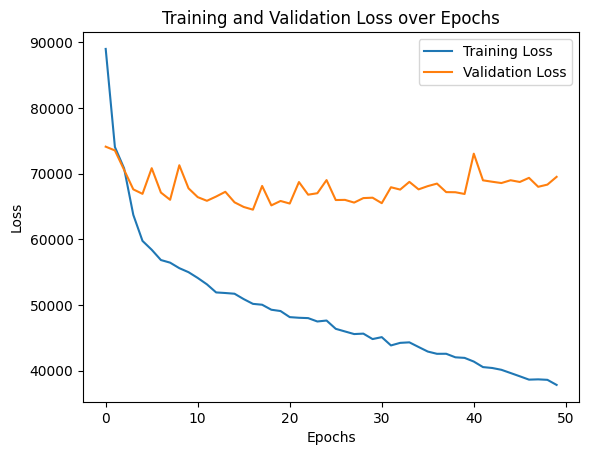

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset

# Load a pretrained ResNet model
pretrained_model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to match your input channels (10 channels)
pretrained_model.conv1 = nn.Conv2d(10, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the fully connected layer to match your output size (1 output for regression)
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 1)

# Define your model
model = pretrained_model

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create dataset
dataset = CandyDataset(df)

# Calculate the size of the training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split dataset into train and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize model, loss, and optimizer
model = CandyCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
# Train the model with loss tracking and plotting
train_model(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=50)


In [13]:
df[df["score"] > 1514][df["score"] < 1515]

/var/folders/n7/7ln3k6zx5hj40n1dc441clm40000gn/T/ipykernel_70672/317442150.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,board,score
4694,"[[6, 5, 5, 2, 6, 6, 3], [3, 2, 3, 4, 1, 6, 5],...",1514.315428


In [3]:
visualize_row(raw, 4694)

Move 1: ((3, 2), (4, 2)), N: 1835, Q: 1514.3154275334068
Move 2: ((4, 2), (5, 2)), N: 25.0, Q: 487.4
Move 3: ((2, 5), (2, 6)), N: 17.0, Q: 296.96078431372547
Move 4: ((4, 4), (4, 5)), N: 17.0, Q: 287.3529411764706
Move 5: ((4, 1), (4, 2)), N: 17.0, Q: 260.0
Move 6: ((2, 1), (3, 1)), N: 16.0, Q: 257.1875
Move 7: ((3, 4), (4, 4)), N: 15.0, Q: 195.66666666666666
Move 8: ((1, 5), (1, 6)), N: 15.0, Q: 193.33333333333334
Move 9: ((3, 1), (3, 2)), N: 15.0, Q: 181.66666666666666
Move 10: ((4, 2), (4, 3)), N: 14.0, Q: 162.85714285714286


SystemExit: 

/Users/alexisbonnafont/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, TensorDataset

# Load a pretrained ResNet50 model
pretrained_model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to match your input channels (12 channels)
pretrained_model.conv1 = nn.Conv2d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the fully connected layer to match your output size (1 output for regression)
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 1)

# Freeze the initial layers
for param in pretrained_model.parameters():
    param.requires_grad = False

# Unfreeze the last few layers
for param in pretrained_model.layer4.parameters():
    param.requires_grad = True

# Unfreeze the fully connected layer
for param in pretrained_model.fc.parameters():
    param.requires_grad = True

# Define your model
model = pretrained_model

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Create dataset
dataset = CandyDataset(df)

# Calculate the size of the training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split dataset into train and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Train the model
# Train the model with loss tracking and plotting
train_model(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=50)

/Users/alexisbonnafont/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/Users/alexisbonnafont/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



Epoch 1/50, Train Loss: 145598.8954, Validation Loss: 150786.6113
Epoch 2/50, Train Loss: 75421.8701, Validation Loss: 113536.2065
Epoch 3/50, Train Loss: 74341.6078, Validation Loss: 80896.4031
Epoch 4/50, Train Loss: 74169.1361, Validation Loss: 75487.3911
Epoch 5/50, Train Loss: 74110.4452, Validation Loss: 79045.9815
Epoch 6/50, Train Loss: 74093.5042, Validation Loss: 83643.0999
Epoch 7/50, Train Loss: 73561.3403, Validation Loss: 105228.4629
Epoch 8/50, Train Loss: 73669.2680, Validation Loss: 86153.2524


KeyboardInterrupt: 

In [17]:
preprocess_board(b.board).shape

(7, 7, 12)

Epoch 1/50, Train Loss: 95037.7288, Validation Loss: 68915.2693
Epoch 2/50, Train Loss: 76476.7411, Validation Loss: 68027.6884
Epoch 3/50, Train Loss: 76443.4929, Validation Loss: 68077.8967
Epoch 4/50, Train Loss: 75352.5196, Validation Loss: 68143.0594
Epoch 5/50, Train Loss: 75454.8567, Validation Loss: 68331.9357
Epoch 6/50, Train Loss: 74574.6175, Validation Loss: 69001.5256
Epoch 7/50, Train Loss: 74178.5429, Validation Loss: 68616.9192
Epoch 8/50, Train Loss: 74132.8262, Validation Loss: 69377.0464
Epoch 9/50, Train Loss: 74148.1936, Validation Loss: 68925.6667
Epoch 10/50, Train Loss: 73632.7770, Validation Loss: 69120.4936
Epoch 11/50, Train Loss: 73326.4961, Validation Loss: 68751.8870
Epoch 12/50, Train Loss: 72796.4878, Validation Loss: 68494.1811
Epoch 13/50, Train Loss: 72334.6014, Validation Loss: 68459.7839
Epoch 14/50, Train Loss: 71154.7981, Validation Loss: 68487.9748
Epoch 15/50, Train Loss: 71101.7087, Validation Loss: 67930.1214
Epoch 16/50, Train Loss: 69761.584

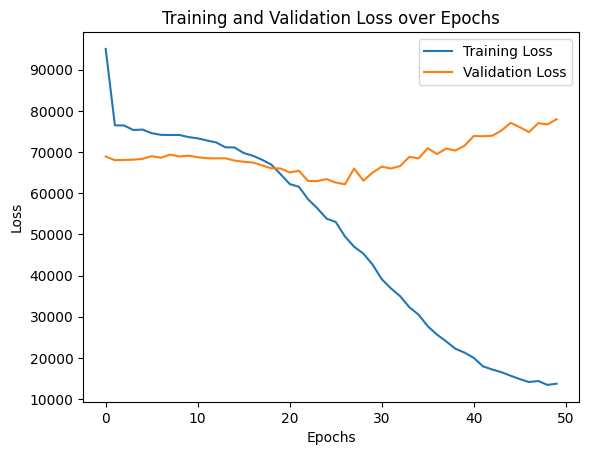

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt

# Example unique IDs and types
unique_ids = [1, 2, 3, 4, 5, 6, 7]
unique_types = ["normal", "sachet", "raye_hor", "raye_ver", "disco"]

# Mapping for one-hot encoding
id_to_index = {id_: idx for idx, id_ in enumerate(unique_ids)}
type_to_index = {type_: idx for idx, type_ in enumerate(unique_types)}

# One-hot encode a single Candy object
def one_hot_encode_candy(candy):
    id_one_hot = np.zeros(len(unique_ids))
    type_one_hot = np.zeros(len(unique_types))
    id_one_hot[id_to_index[candy.id]] = 1
    type_one_hot[type_to_index.get(candy.type, 0)] = 1  # Default to first index if type missing
    return np.concatenate([id_one_hot, type_one_hot])

# Convert a 7x7 grid of Candy objects to a numerical 3D array
def preprocess_board(board):
    grid_size = (7, 7)
    encoded_board = np.zeros((*grid_size, len(unique_ids) + len(unique_types)))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            encoded_board[i, j, :] = one_hot_encode_candy(board[i][j])
    return encoded_board

class CandyDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.min_score = dataframe['score'].min()
        self.max_score = dataframe['score'].max()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        board = self.dataframe.iloc[idx, 0]  # Board state
        score = self.dataframe.iloc[idx, 1]  # Score
        processed_board = preprocess_board(board)
        return torch.tensor(processed_board, dtype=torch.float32), torch.tensor(score, dtype=torch.float32)

# Define the MLP model
class CandyMLP(nn.Module):
    def __init__(self):
        super(CandyMLP, self).__init__()
        input_size = 7 * 7 * (len(unique_ids) + len(unique_types))  # Flattened input size
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(64, 1) # Single output for regression

    def forward(self, x):
        x = x.reshape(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Modified training function to track training and validation loss
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs.permute(0, 3, 1, 2))  # Adjust dimensions to (N, C, H, W)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation during validation
            for inputs, targets in val_dataloader:
                outputs = model(inputs.permute(0, 3, 1, 2))  # Adjust dimensions to (N, C, H, W)
                loss = criterion(outputs.squeeze(), targets)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        # Print the losses
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    
    # Plot training and validation losses
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss over Epochs')
    plt.show()

# Example usage
# Assuming you have a DataFrame `df` with the board states and scores
dataset = CandyDataset(df)

# Calculate the size of the training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split dataset into train and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize model, loss, and optimizer
model = CandyMLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=50)